In [2]:
#!pip install albumentations

     -------------------------------------- 116.7/116.7 kB 6.7 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from glob import glob
from tqdm import tqdm

In [22]:
transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    #A.OpticalDistortion(p=.2),
    
    
    A.OneOf([
        A.augmentations.transforms.GaussNoise(),
        A.GaussNoise(),
    ], p=.2),
    
    A.ShiftScaleRotate(shift_limit=.0625, scale_limit=0.4, rotate_limit=45, p=.5),
    
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3,p=.1),
        A.Blur(blur_limit=3,p=.1),
    ], p=.2),
    
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.augmentations.transforms.Sharpen (),
        A.augmentations.transforms.Emboss(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(gamma_limit=(90, 110)),
        A.HueSaturationValue(p=.3),
        ], p=.3),
    
    #A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255), # 정규화
    
    
    
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],)
)

In [13]:
def myFig(img, label) :
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    if len(label)>0 :
        for _ in range(len(label)):
            
            # Create a Rectangle patch
            dw = img.shape[1]
            dh = img.shape[0]

            x1 = (label[_][0] - label[_][2] / 2) * dw
            y1 = (label[_][1] - label[_][3] / 2) * dh
            w = label[_][2] * dw
            h = label[_][3] * dh
            rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()

In [14]:
def bbox_file(file):
    basename = os.path.basename(file)
    filename = os.path.splitext(basename)[0]
    bboxes = np.loadtxt(file, delimiter=" ",ndmin=2)
    bboxes = np.roll(bboxes, 4, axis=1).tolist()
    return bboxes

In [23]:
def transform_img(image, bboxes, outpath, filename, k):
    transformed = transform(image = image, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    im = Image.fromarray(transformed_image,'RGB')

    
    outpath_img = os.path.join(outpath,'img/')  # img 저장 경로
    im.save(outpath_img+filename+'_'+str(k)+'.jpg')
    
    outpath_anno = os.path.join(outpath,'anno/')  # txt 저장 경로
    file = open(outpath_anno+filename+'_'+str(k)+'.txt', "w")
    

    l = ''
    for t in transformed_bboxes:
        for n,j in enumerate(t):
            l += str(j)+' '
        l += '\n'
        
    file.write(l)
    file.close()
    
    #print(transformed_image.shape)
    #print(transformed_bboxes)
    myFig(transformed_image,transformed_bboxes)

## dataset 불러오기

### train dataset

In [16]:
## 이미지 불러오기
def img_load(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [17]:
os.chdir("C:/Users/jooye/OneDrive - dongguk.edu/data campus/data/")   # 경로 설정

In [18]:
#train
train_path = 'vd6/vd' # 이미지 파일 경로
train = sorted(glob(os.path.join(train_path,'*.jpg')))

In [19]:
train_imgs = [img_load(m) for m in tqdm(train)]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.53it/s]


In [20]:
train_anno_path = "C:/Users/jooye/OneDrive - dongguk.edu/data campus/data/vd6/anno/" # txt 파일 경로
train_anno = glob(os.path.join(train_anno_path, '*.txt'))

### augmentation 실행

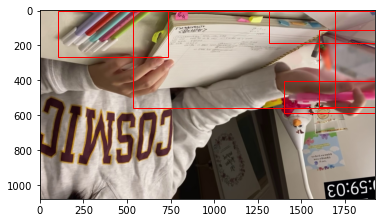

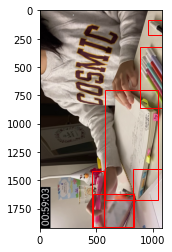

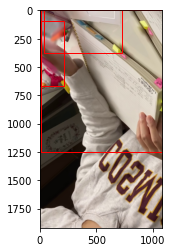

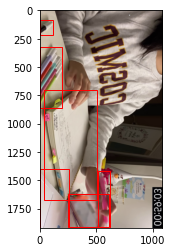

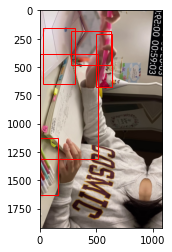

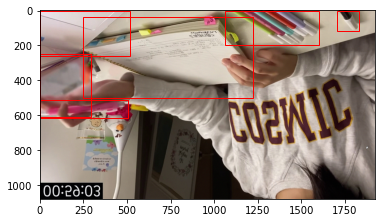

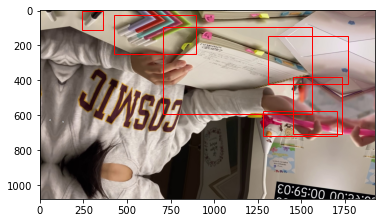

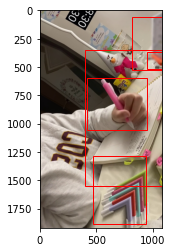

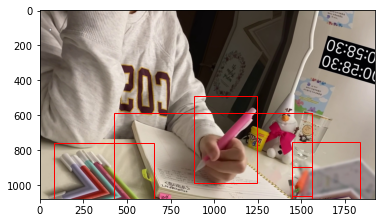

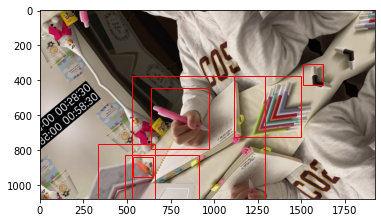

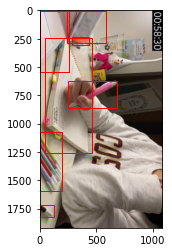

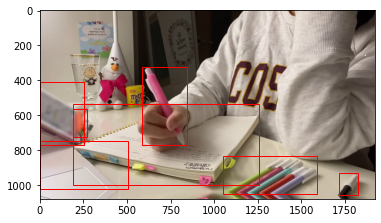

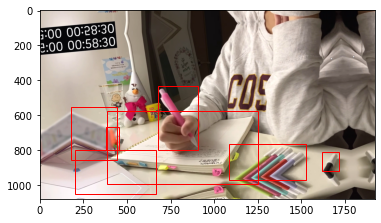

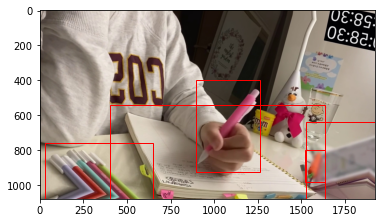

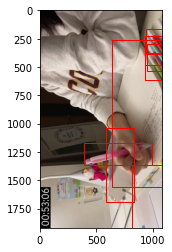

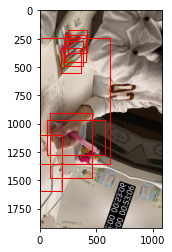

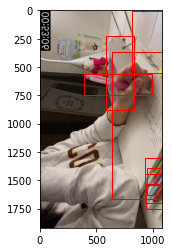

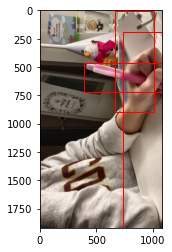

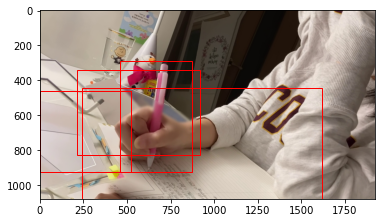

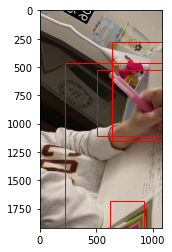

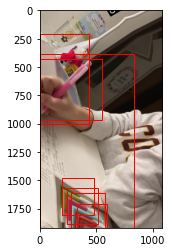

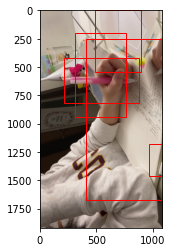

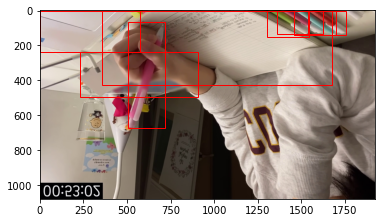

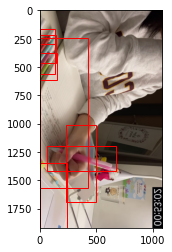

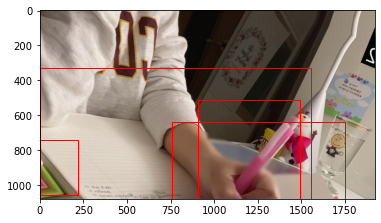

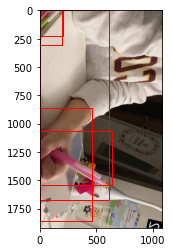

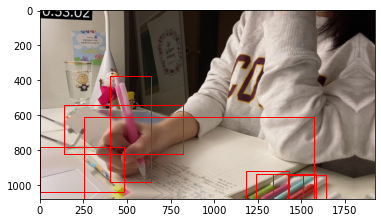

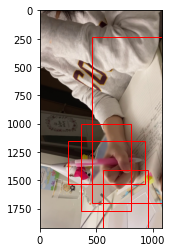

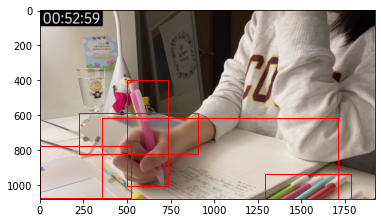

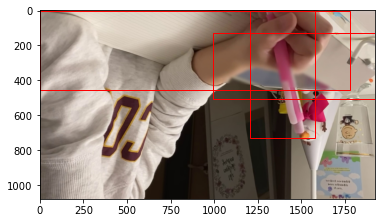

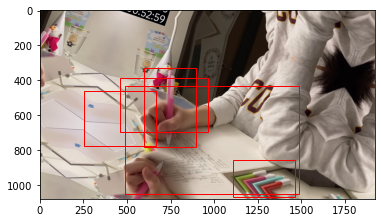

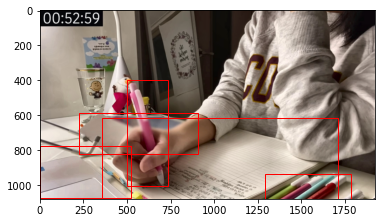

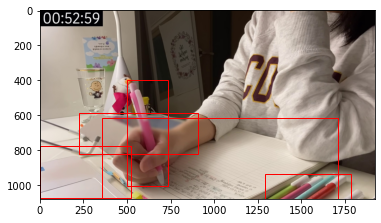

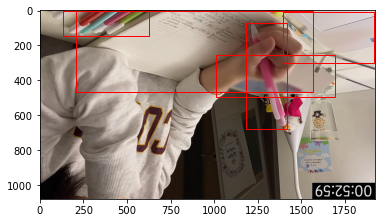

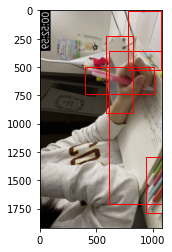

In [24]:
outpath = "C:/Users/jooye/OneDrive - dongguk.edu/data campus/aug/output_vd6" # 저장할 경로 

i = 0
for file in train_anno:
    basename = os.path.basename(file)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(train_path, f"{filename}.jpg")):
        print(f"{filename} image does not exist!")
        continue
    
    image = train_imgs[i]
    
    bboxes = bbox_file(file)
    for j in range(7):
        transform_img(image=image, bboxes=bboxes, outpath=outpath, filename=filename, k=j)
        
    i+=1